# Otto商品分类——线性SVM

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，分别调用
缺省参数LinearSVC、
LinearSVC + CV进行参数调优（手动实现循环）。

Otto数据集是著名电商Otto提供的一个多类商品分类问题，类别数=9. 每个样本有93维数值型特征（整数，表示某种事件发生的次数，已经进行过脱敏处理）。 竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data


In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

#竞赛的评价指标为logloss，但LinearSVC不支持概率
#所以在这个例子中我们用正确率accuracy_score作为模型选择的度量
#如果要将LinearSVC的输出转换成概率，可通过概率校准工具CalibratedClassifierCV实现概率转换。
#SVC也是通过类似的方式支持概率输出。
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt

#显示中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

## 读取数据 

In [2]:
# 读取数据
# path to where the data lies
dpath = './data/'

# 采用原始特征 + tf_idf特征
#原始特征 + tf_idf特征对线性SVM训练还是很快，RBF核已慢得不行
# RBF核只用tf_idf特征
train1 = pd.read_csv(dpath +"Otto_FE_train_org.csv")
train2 = pd.read_csv(dpath +"Otto_FE_train_tfidf.csv")
#train = pd.read_csv(dpath +"Otto_FE_train_tfidf.csv")

#去掉多余的id
train2 = train2.drop(["id","target"], axis=1)
train =  pd.concat([train1, train2], axis = 1, ignore_index=False)
train.head()

del train1
del train2

In [3]:
#train.info()

## 准备数据

In [4]:
# 将类别字符串变成数字
# drop ids and get labels
y_train = train['target']   #形式为Class_x
X_train = train.drop(["id", "target"], axis=1)

#保存特征名字以备后用（可视化）
feat_names = X_train.columns 

#sklearn的学习器大多之一稀疏数据输入，模型训练会快很多
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)

In [5]:
# 训练样本6w+，交叉验证太慢，用train_test_split估计模型性能
# SVM对大样本数据集支持不太好
from sklearn.model_selection import train_test_split
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, train_size = 0.8,random_state = 0)

/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
print (X_train_part.shape)

(49502, 186)


## 模型训练

### 默认参数的 SVC

In [7]:
from sklearn.svm import LinearSVC

In [8]:
#LinearSVC不能得到每类的概率（只有predict函数，没有predict_proba函数），
#在Otto数据集要求输出每类的概率，这里只是示意SVM的使用方法
#https://xacecask2.gitbooks.io/scikit-learn-user-guide-chinese-version/content/sec1.4.html
#1.4.1.2. 得分与概率
#1. 生成学习器实例
SVC1 = LinearSVC()

#2. 模型训练
SVC1.fit(X_train_part, y_train_part)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [9]:
#3. 在校验集上测试，估计模型性能
y_predict = SVC1.predict(X_val)

print("accuracy is: ",accuracy_score(y_val, y_predict))

print("Classification report for classifier %s:\n%s\n"
      % (SVC1, classification_report(y_val, y_predict)))
print("Confusion matrix:\n%s" % confusion_matrix(y_val, y_predict))

('accuracy is: ', 0.76430187459599219)
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):
             precision    recall  f1-score   support

    Class_1       0.59      0.35      0.44       370
    Class_2       0.65      0.86      0.74      3205
    Class_3       0.52      0.35      0.41      1546
    Class_4       0.76      0.15      0.25       566
    Class_5       0.95      0.96      0.95       542
    Class_6       0.93      0.92      0.93      2823
    Class_7       0.69      0.62      0.66       572
    Class_8       0.86      0.92      0.89      1703
    Class_9       0.83      0.85      0.84      1049

avg / total       0.76      0.76      0.75     12376


Confusion matrix:
[[ 129   16    3    0    1   41   10   77   93]
 [   3 2762  361   10   12   12   23   14    8]
 [   1 

使用原始特征 + tfidf特征的线性SVM分类性能：accuracy is： 0.76430187459599219

class_1,class_3和class_4分类效果不好。
是因为这几类样本数目少？（class_6类的样本数目也不多）。后面采用类别权重试试
(用class_weight='balanced'效果更差了,不过也就差一点点)

### 线性SVM正则参数调优

线性SVM LinearSVC的需要调整正则超参数包括C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和正则函数penalty（L2/L1） 

采用交叉验证，网格搜索步骤与Logistic回归正则参数处理类似，在此略。

这里我们用校验集（X_val、y_val）来估计模型性能

In [10]:
#单组超参数情况，模型在训练集上训练，在校验集上的测试的测试性能
def fit_grid_point_Linear(C, X_train, y_train, X_val, y_val):
    
    # 在训练集上训练SVC
    SVC2 =  LinearSVC( C = C)
    SVC2 = SVC2.fit(X_train, y_train)
    
    # 在校验集上返回accuracy
    accuracy = SVC2.score(X_val, y_val)
    
    print("C= {} : accuracy= {} " .format(C, accuracy))
    return accuracy

C= 0.1 : accuracy= 0.758322559793 
C= 1.0 : accuracy= 0.764301874596 
C= 10.0 : accuracy= 0.76567550097 
C= 100.0 : accuracy= 0.765837104072 
C= 1000.0 : accuracy= 0.726648351648 


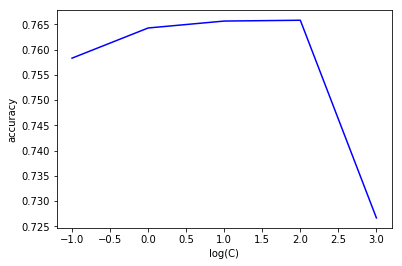

In [11]:
#需要调优的参数
#SVM太慢，每次只调一个参数（这里只调C，penalty为‘l2'）
C_s = np.logspace(-1, 3, 5)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份  
#penalty_s = ['l1','l2']

accuracy_s = []
for i, oneC in enumerate(C_s):
#    for j, penalty in enumerate(penalty_s):
    tmp = fit_grid_point_Linear(oneC, X_train_part, y_train_part, X_val, y_val)
    accuracy_s.append(tmp)

x_axis = np.log10(C_s)
#for j, penalty in enumerate(penalty_s):
plt.plot(x_axis, np.array(accuracy_s), 'b-')
    
plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'accuracy' )
#plt.savefig('SVM_Otto.png' )

plt.show()

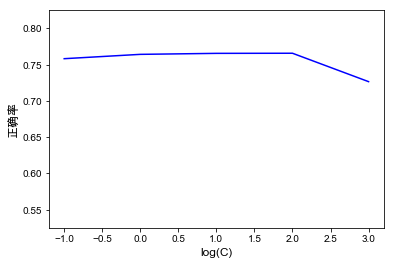

In [6]:
C_s = np.logspace(-1, 3, 5)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份  
#penalty_s = ['l1','l2']

accuracy_s = [0.758322559793, 0.764301874596 , 0.76567550097, 0.765837104072, 0.726648351648 ]

plt.plot(np.log10(C_s), np.array(accuracy_s), 'b-')
plt.xlabel( 'log(C)' ,fontsize = 12)                                                                                                      
plt.ylabel( u'正确率',fontsize = 12 )

plt.ylim(0.525, 0.825)

plt.savefig('RBF_SVM_Otto.png' )

plt.show()

In [12]:
### 最佳超参数
index = np.argmax(accuracy_s, axis=None)
Best_C = C_s[ index ]

print(Best_C)

100.0


## 找到最佳参数后，用全体训练数据训练模型

In [13]:
# SVC训练SVC，支持概率输出
Best_C = 100

SVC3 = LinearSVC(C = Best_C)
SVC3.fit(X_train, y_train)

#保持模型，用于后续测试
import cPickle
cPickle.dump(SVC3, open("Otto_LinearSVC.pkl", 'wb'))